In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

In [2]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-25 09:49:35.188280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748166575.416919      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748166575.480825      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
import os
import shutil
import random

# 原始路徑
original_train_dir = '/kaggle/input/dog-breed-identification/train'

# 讀取標籤csv
labels_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')

# 自動取得所有類別
all_classes = sorted(labels_df['breed'].unique())

# 新資料夾路徑
new_base_dir = './data_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

# 拆分比例
train_prop = 0.7
val_prop = 0.2  # 測試集將佔剩下的 0.1

# 建立資料夾結構
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    for cls in all_classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)

# 依類別拆分並複製圖片
for cls in all_classes:
    cls_files = labels_df[labels_df['breed'] == cls]['id'].tolist()
    random.shuffle(cls_files)

    num_total = len(cls_files)
    num_train = int(num_total * train_prop)
    num_val = int(num_total * val_prop)
    num_test = num_total - num_train - num_val

    train_files = cls_files[:num_train]
    val_files = cls_files[num_train:num_train + num_val]
    test_files = cls_files[num_train + num_val:]

    # 複製 train 圖片
    for file_id in train_files:
        src_path = os.path.join(original_train_dir, file_id + '.jpg')
        dst_path = os.path.join(train_dir, cls, file_id + '.jpg')
        shutil.copy(src_path, dst_path)

    # 複製 val 圖片
    for file_id in val_files:
        src_path = os.path.join(original_train_dir, file_id + '.jpg')
        dst_path = os.path.join(val_dir, cls, file_id + '.jpg')
        shutil.copy(src_path, dst_path)

    # 複製 test 圖片
    for file_id in test_files:
        src_path = os.path.join(original_train_dir, file_id + '.jpg')
        dst_path = os.path.join(test_dir, cls, file_id + '.jpg')
        shutil.copy(src_path, dst_path)

print("全部資料拆分完成，共處理 %d 類別。" % len(all_classes))


全部資料拆分完成，共處理 120 類別。


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

img_height = 224
img_width = 224
batch_size = 32

# 訓練資料增強
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7101 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.


In [5]:
from tensorflow.keras.applications import Xception, ResNet50, InceptionResNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 圖片大小與類別數
input_shape = (224, 224, 3)
num_classes = train_generator.num_classes  # 120 類別

# 輸入層
inputs = Input(shape=input_shape)

# 每個模型都接一樣的輸入
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# 冷凍 base models
xception_base.trainable = False
resnet_base.trainable = False
inception_resnet_base.trainable = False

# 取得各模型的特徵輸出
x1 = xception_base(inputs)
x2 = resnet_base(inputs)
x3 = inception_resnet_base(inputs)

# 各自做 GAP
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)

# 合併特徵
merged = Concatenate()([x1, x2, x3])

# 最終分類層
outputs = Dense(num_classes, activation='softmax')(merged)

# 定義模型
model = Model(inputs, outputs)

# 編譯模型
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 顯示模型結構
model.summary()


I0000 00:00:1748166630.447893      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xception (Functional)     │ (None, 7, 7, 2048)     │     20,861,480 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_resnet_v2       │ (None, 5, 5, 1536)     │     54,336,736 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ xception[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ inception_resnet_v2[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5632)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 120)            │        675,960 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,461,888 (379.42 MB)

 Trainable params: 675,960 (2.58 MB)

 Non-trainable params: 98,785,928 (376.84 MB)

In [6]:
print(train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748166691.167726     113 service.cc:148] XLA service 0x7bc2f8003820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748166691.168650     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748166697.900216     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748166710.669300     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/221 ━━━━━━━━━━━━━━━━━━━━ 192s 600ms/step - accuracy: 0.5539 - loss: 2.1885 - val_accuracy: 0.8261 - val_loss: 0.6654
Epoch 2/30
  1/221 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.8438 - loss: 0.7161

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8438 - loss: 0.7161 - val_accuracy: 0.8306 - val_loss: 0.6511
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 97s 437ms/step - accuracy: 0.7987 - loss: 0.6961 - val_accuracy: 0.8246 - val_loss: 0.6914
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8750 - loss: 0.3965 - val_accuracy: 0.8281 - val_loss: 0.6907
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 96s 434ms/step - accuracy: 0.8221 - loss: 0.6137 - val_accuracy: 0.8196 - val_loss: 0.7471
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6875 - loss: 1.2915 - val_accuracy: 0.8221 - val_loss: 0.7466
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 427ms/step - accuracy: 0.8425 - loss: 0.5341 - val_accuracy: 0.8256 - val_loss: 0.7338
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8438 - loss: 0.6304 - val_accuracy: 0.8251 - val_loss: 0.7247
Epoch 9/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.8353 - loss: 0.5527 - val_acc

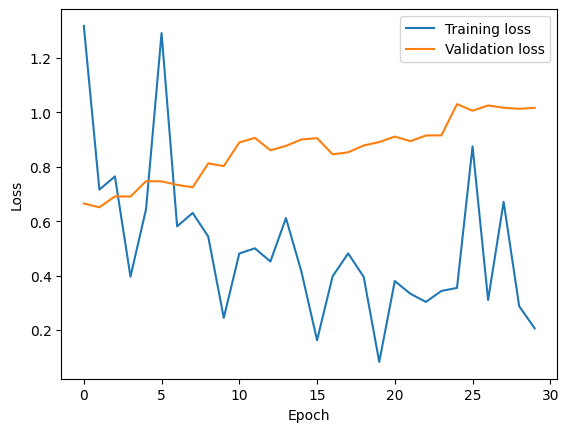

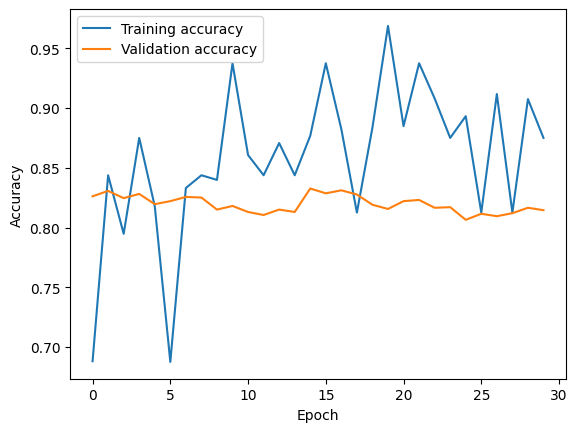

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# 將索引轉換為對應的類別名稱
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}  # key: index, value: class name

from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/kaggle/input/dog-breed-identification/test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/dog-breed-identification',  # 注意是上層資料夾
    classes=['test'],  # 指定子資料夾名稱
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# 預測所有測試圖片
predictions = model.predict(test_generator)

# 將預測機率轉為類別索引
predicted_indices = np.argmax(predictions, axis=1)

# 將索引轉為類別名稱
predicted_labels = [class_names[idx] for idx in predicted_indices]

# 真實標籤（以目錄分類命名為準）
true_indices = test_generator.classes
true_labels = [class_names[idx] for idx in true_indices]

# 可選：顯示前幾筆檢查
for i in range(10):
    print(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")


Found 10357 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 142s 371ms/step
True: affenpinscher, Predicted: japanese_spaniel
True: affenpinscher, Predicted: samoyed
True: affenpinscher, Predicted: english_setter
True: affenpinscher, Predicted: pug
True: affenpinscher, Predicted: tibetan_terrier
True: affenpinscher, Predicted: miniature_poodle
True: affenpinscher, Predicted: australian_terrier
True: affenpinscher, Predicted: samoyed
True: affenpinscher, Predicted: irish_wolfhound
True: affenpinscher, Predicted: sussex_spaniel


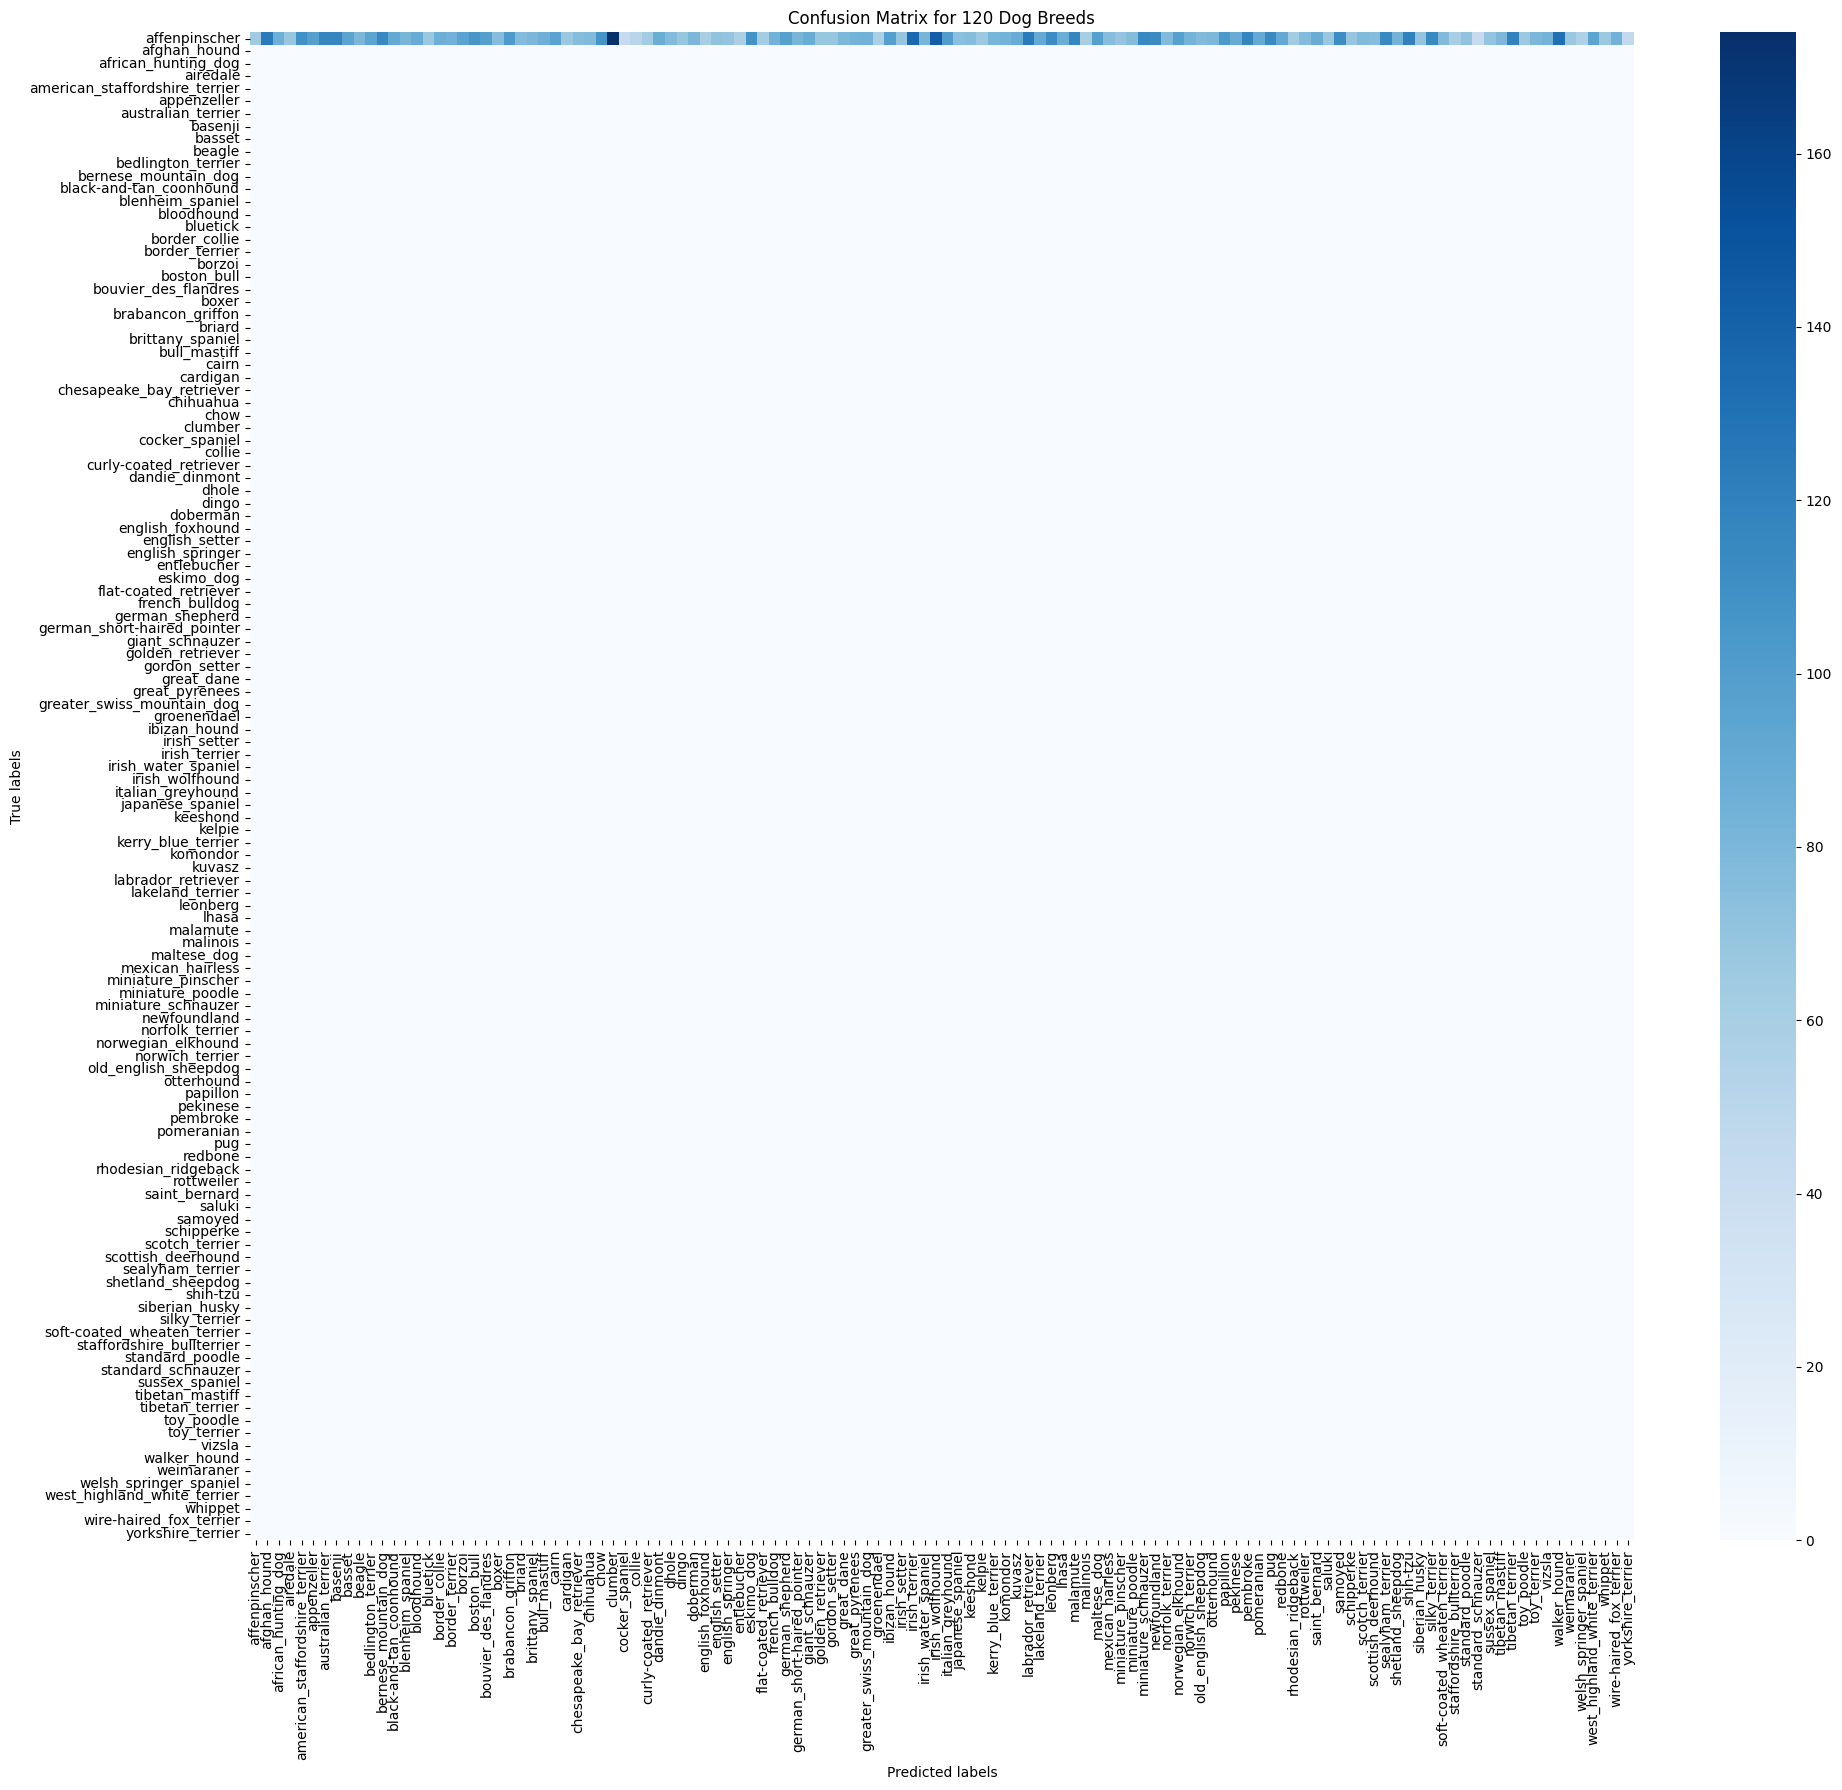

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 確保使用數字 label
cm = confusion_matrix(true_indices, predicted_indices)

# 將 class_names 轉為 list，並依 index 排序（0~119）
sorted_class_names = [class_names[i] for i in range(len(class_names))]

# 畫出混淆矩陣
plt.figure(figsize=(20, 18))  # 可視需要調整大小
sns.heatmap(cm, annot=False, cmap='Blues', 
            xticklabels=sorted_class_names, 
            yticklabels=sorted_class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for 120 Dog Breeds')
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import os

# 預測
predictions = model.predict(test_generator, verbose=1)

# 取得 ID
ids = [os.path.splitext(os.path.basename(path))[0] for path in test_generator.filepaths]

# 類別名稱需按照 train_generator.class_indices 排序
class_names = list(train_generator.class_indices.keys())

# 建立 submission DataFrame
submission = pd.DataFrame(predictions, columns=class_names)
submission.insert(0, 'id', ids)

# 儲存
submission.to_csv('submission.csv', index=False)
print("submission.csv 已儲存成功，總列數：", len(submission))


324/324 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step
submission.csv 已儲存成功，總列數： 10357


In [19]:
print(submission.shape)  # 應該是 (10357, 121)


(10357, 121)
